# Simulating a noisy 16-QAM

This tutorial presents the steps for simulating a noisy 16-QAM modulation scheme with `aff3ct`. At the end of this, tutorial you will have built the following communication sequence.

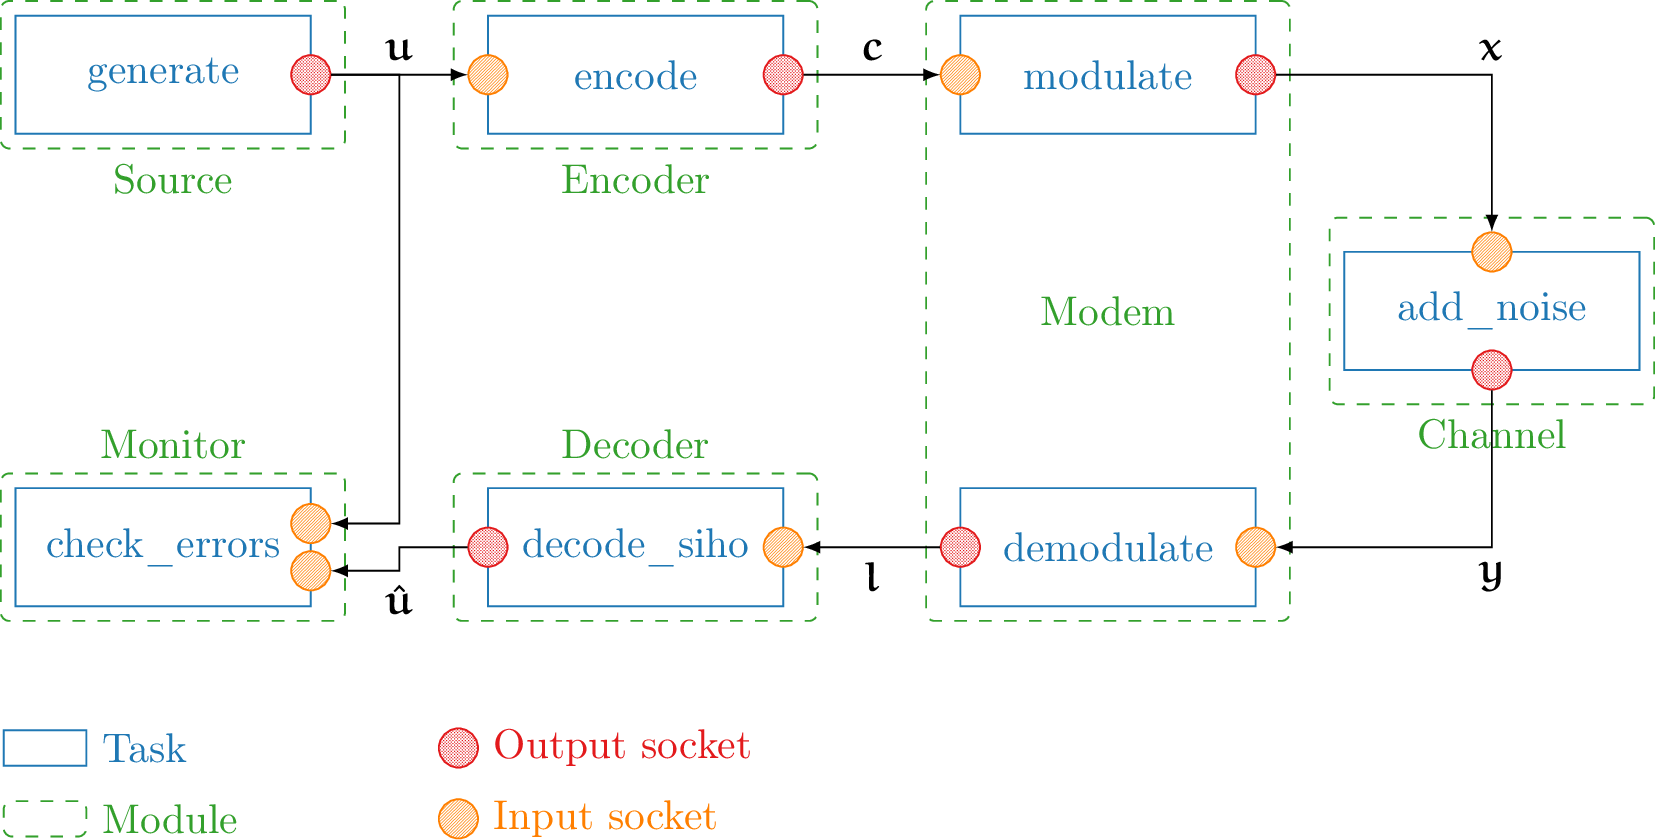

In [14]:
from IPython.display import display, Image
display(Image(filename='img/16QAM_chain/16QAM_chain.png', width = 500))

Before going farther, we should import the `py_aff3ct`library. The sys library is requiered to add the library path to your path. For this example, we will also need the `numpy` library.

In [2]:
import sys  
sys.path.insert(0, '../build')

import py_aff3ct

import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

We start by building all the necessary objects for our simulation:
* a source
* a modem
* an AWGN channel

In [3]:
K   = 4096   # Packet size in bits
bps = 4      # Bits per Symbols   
Ns  = K//bps # Packet size in symbols

src  = py_aff3ct.module.source.Source_random(K)             # Build source
cstl = py_aff3ct.tools.constellation.Constellation_QAM(bps) # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic(K, cstl)        # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR(2*Ns)      # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_NO(K)               # Build the decoder (for taking decisions)
mnt  = py_aff3ct.module.monitor.Monitor_BFER(K,1)           # Build the monitor (counting errors)

Now we can perform the binding steps.

In [4]:
mdm[    'modulate::X_N1'].bind(src[   'generate::U_K' ])
chn[   'add_noise::X_N' ].bind(mdm[   'modulate::X_N2'])
mdm[  'demodulate::Y_N1'].bind(chn[  'add_noise::Y_N' ])
dec[ 'decode_siho::Y_N' ].bind(mdm[ 'demodulate::Y_N2'])
mnt['check_errors::U'   ].bind(src[   'generate::U_K' ])
mnt['check_errors::V'   ].bind(dec['decode_siho::V_K' ])

If you look at the information for tasks `add_noise` and `demodulate`, you will found out that a socket named `CP` should be filled. `CP` stands for "Channel Parameter", which for Additive White Gaussian Noise (AWGN) channel, represents the noise variance. Let now fill this socket with a user defined value.

In [5]:
sigma2 = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma2[0] = 0.05

chn[' add_noise::CP'].bind(sigma2)
mdm['demodulate::CP'].bind(sigma2)
print("Channel Parameter (CP) for 'chn':", chn[' add_noise::CP'][:])
print("Channel Parameter (CP) for 'mdm':", mdm['demodulate::CP'][:])

Channel Parameter (CP) for 'chn': [[0.05]]
Channel Parameter (CP) for 'mdm': [[0.05]]


Execute the first part of the sequence.

In [6]:
src('generate'   ).exec()
mdm('modulate'   ).exec()
chn('add_noise'  ).exec()
mdm('demodulate' ).exec()
dec('decode_siho').exec()

In [7]:
sent_signal = mdm['  modulate::X_N2'][:]
recv_signal = mdm['demodulate::Y_N1'][:]

<IPython.core.display.Javascript object>


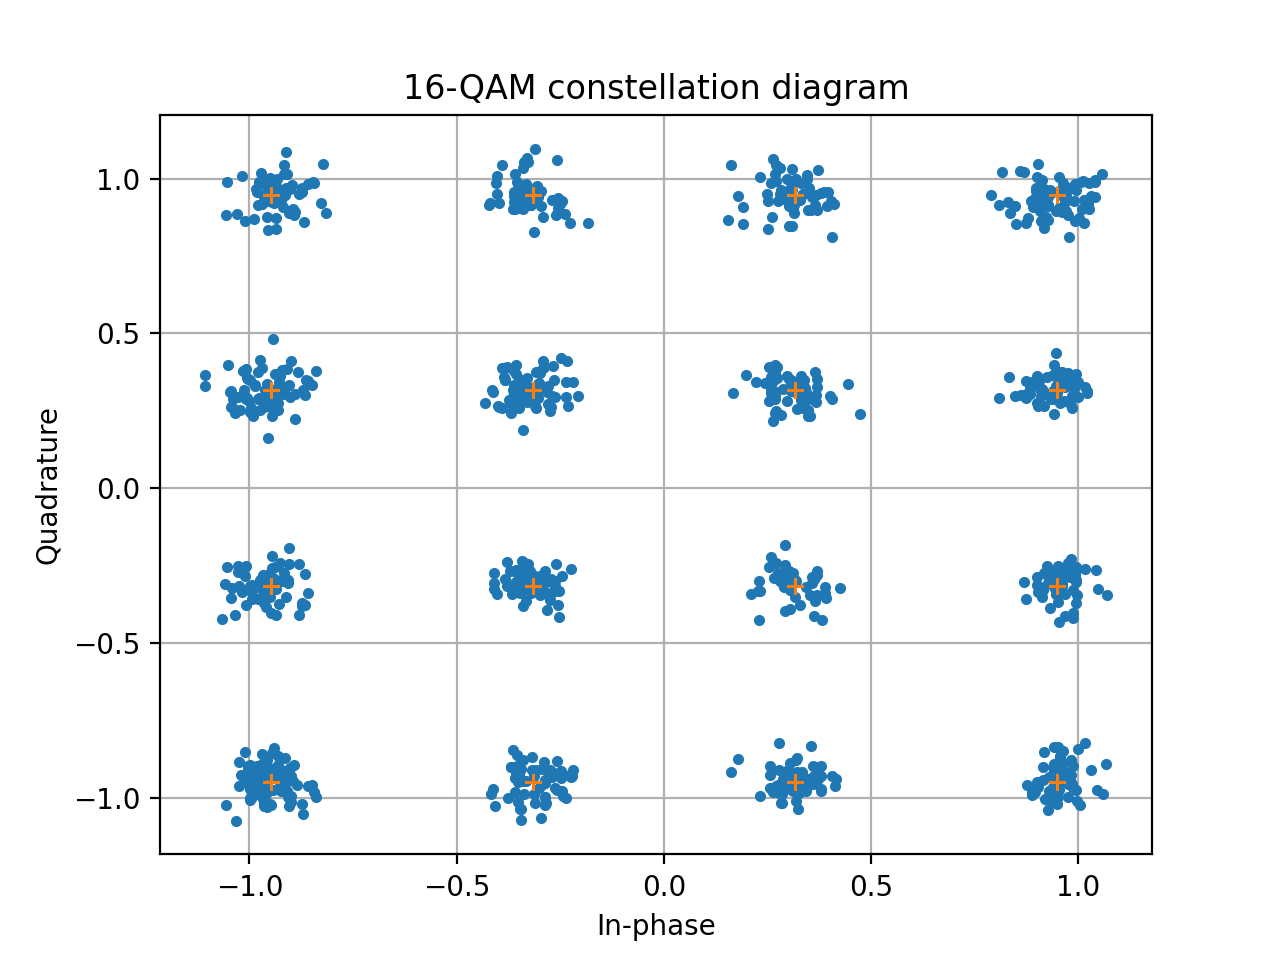

In [8]:
plt.plot(recv_signal[0, ::2], recv_signal[0, 1::2], '.');
plt.plot(sent_signal[0, ::2], sent_signal[0, 1::2], '+');
plt.title("16-QAM constellation diagram")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid()

In [9]:
mnt('check_errors').debug = True
mnt('check_errors').set_debug_limit(8)
mnt('check_errors').exec()

# Monitor_BFER::check_errors(const int32 U[4096], const int32 V[4096])
# {IN}  U = [    0,     1,     1,     0,     1,     1,     1,     1, ...]
# {IN}  V = [    0,     1,     1,     0,     1,     1,     1,     1, ...]
# Returned status: [0 'SUCCESS']
#
